# Tree SHAP

## Definition and intuition

SHAP is the method that unifies many additive feature attribution methods, by giving a strong theoretical background inspired by coalitional game theory.
The true feature attribution is the one one that satisfies two important criteria : 
* Local accuracy: the sum of all feature attributions is the value predicted by the model 
* Consistency: When we change the model such that it relies more on a certain feature then the attributed importance for that feature should not decrease  

With these two properties we can have a theoretical guarantee on the uniqueness of the feature attribution value, the shapely value.  
For trees there is a heuristic method called TreeInterpreter ([see notebook](treeinterpreter.ipynb))  
But is has been shown (Interpretable Machine Learning with XGBoost(https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)) that this method is inconsistent.  
So tree SHAP comes to adapt this method in order to find the shapely values and respect the two feature attribution properties.
It basically looks at all possible subsets of features and computes the expected value for each subset, and then gives the traditional Shapely value

## Interpretability with tree SHAP

### Characteristics 
* Model-specific: This method is specific to tree based models (decision trees, random forest, XGBoost...) 
* Local: we explain the decision for a single sample  

NB: If we compute mean(|tree_shap|) this gives us global interpretability that is more consistent than gain or split based feature importance.

## Importations
The implementation of SHAP used in this notebook is from the implementation of one of the creators ([see on GitHub](https://github.com/slundberg/shap))

In [1]:
# specific importations to SHAP
import shap

# Importing black box models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import classification_report

# import datasets
from mlinutils.datasets import Bikes, Loans

import mlinutils.sanity as san

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately 
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>.
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset">see lending club dataset exploration</a> 

### Data importation 

In [3]:
# Importing bike sharing and lending club data set
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load()

### Data preview
Take a peak into the data we'll be using !

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


season  year     month      hour  holiday   week_day  working_day  \
4875     fall   0.0      July   9pm-5am      0.0  Wednesday          1.0   
17159  spring   1.0  December   5pm-8pm      0.0   Saturday          0.0   
15704  winter   1.0   October  11am-4pm      0.0     Sunday          0.0   
7981   winter   0.0  December   9pm-5am      0.0     Sunday          0.0   
751    spring   0.0  February   5pm-8pm      0.0   Thursday          1.0   

      weather_situation  temperature  felt_temperature  humidity  wind_speed  \
4875               Good        31.98            35.605      49.0     12.9980   
17159              Good        10.66            10.605      44.0     31.0009   
15704              Good        22.96            26.515      37.0     16.9979   
7981               Good        10.66            15.150      81.0      0.0000   
751                Good         8.20             9.850      40.0     12.9980   

       count  days_since_2011  
4875    10.0            207.0  
17159   82.0            721.0  
15704  626.0            659.0  
7981     4.0            337.0  
751    175.0             33.0

## Application

### Plan
The tree based model that we are going to explain is random forests for both regression (bike sharing) and classification (lending club) task:
* <a href=#reg>Regression with Bike Sharing</a>
    * <a href=#regm> Model creation and sanity checks</a>
    * <a href=#rege> Explanation </a>
* <a href=#clf>Classification with Lending Club</a>
    * <a href=#clfm> Model creation and sanity checks </a>
    * <a href=#clfe> Explanation </a>
* <a href=#conc>Conclusion</a>

### Regression with Bike Sharing <a name=reg>

#### Model creation and sanity checks <a name=regm>

In [5]:
bike_rf = RandomForestRegressor(n_estimators=300, max_depth=12, max_features="sqrt", random_state=22)
bike_rf = bike_rf.fit(bk_X_train, bk_y_train)

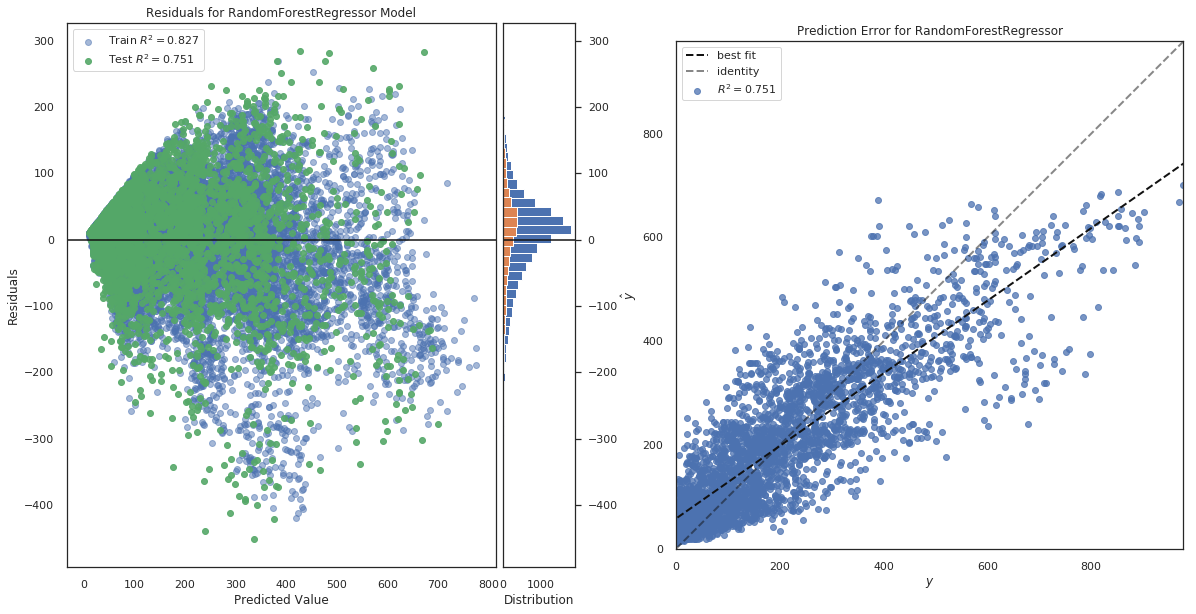

In [6]:
san.regression_sanity_check(bike_rf, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

#### Explanation <a name=rege>

In [7]:
bikes_tree_explainer = shap.TreeExplainer(bike_rf)

In [8]:
sample_bike = bk_X_test.iloc[55]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

season  year     month     hour  holiday week_day  working_day  \
16133  winter   1.0  November  9pm-5am      0.0   Friday          1.0   

      weather_situation  temperature  felt_temperature  humidity  wind_speed  \
16133              Good        13.12            16.665      81.0      6.0032   

       count  days_since_2011  
16133  162.0            678.0

In [9]:
sample_bike_shap_values = bikes_tree_explainer.shap_values(sample_bike)

In [10]:
shap.initjs()
shap.force_plot(bikes_tree_explainer.expected_value, sample_bike_shap_values, sample_bike, feature_names=bk_X_train.columns)

In [11]:
bk_X_test_samples = bk_X_test.sample(frac=0.2)

In [12]:
bike_samples_shap_values = bikes_tree_explainer.shap_values(bk_X_test_samples)

In [13]:
# visualize 20% of test set 
shap.force_plot(bikes_tree_explainer.expected_value, bike_samples_shap_values, bk_X_test_samples)

We can understand how a single feature effects the output of the model

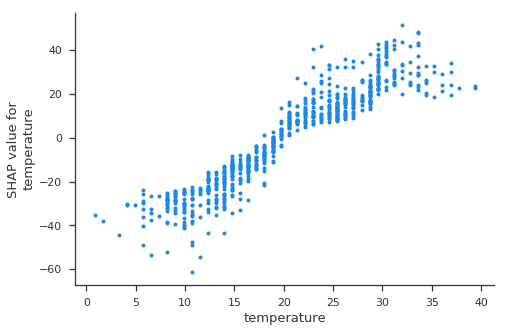

In [14]:
# create a SHAP dependence plot to show the effect of a single feature across multiple samples of test set
shap.dependence_plot("temperature", bike_samples_shap_values, bk_X_test_samples, interaction_index=None)

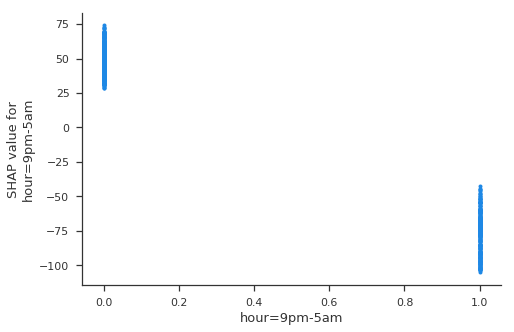

In [15]:
# binary feature
shap.dependence_plot("hour=9pm-5am", bike_samples_shap_values, bk_X_test_samples, interaction_index=None)

### Summarize the effects of all the features for bike sharing rentals

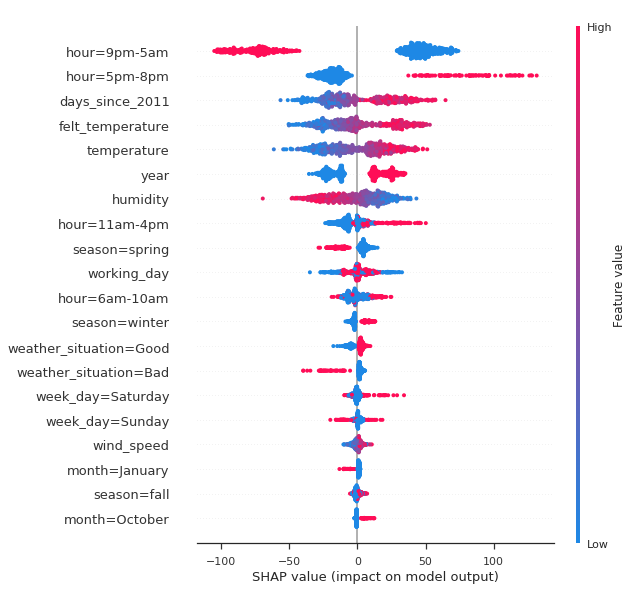

In [16]:
shap.summary_plot(bike_samples_shap_values, bk_X_test_samples)

### Classification with lending club <a name=clf>

In [17]:
# Importing lending club data set
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test = loans.load()

In [18]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


loan_amnt  int_rate  installment  grade  emp_length home_ownership  \
3594      3500.0     17.27       125.26    5.0         4.0           RENT   
7157     10475.0     17.57       263.56    4.0         5.0            OWN   
41291    20000.0     17.14       498.56    4.0        10.0           RENT   
87788    16000.0     11.99       531.36    6.0         6.0       MORTGAGE   
88831     5275.0      5.42       159.10    7.0         8.0            OWN   

       annual_inc verification_status             purpose    dti  delinq_2yrs  \
3594      62000.0            Verified         credit_card  11.25          0.0   
7157      52000.0     Source Verified  debt_consolidation  16.96          1.0   
41291     55000.0     Source Verified  debt_consolidation  20.88          0.0   
87788     35000.0            Verified  debt_consolidation  20.51          0.0   
88831    120000.0        Not Verified    home_improvement   5.71          0.0   

       inq_last_6mths  open_acc  revol_bal  revol_util  open_acc_6m  inq_fi  \
3594              2.0       5.0     3074.0        90.4          1.0     1.0   
7157              0.0       8.0     2981.0        31.7          1.0     1.0   
41291             1.0       7.0    21046.0        72.3          1.0     1.0   
87788             2.0      13.0     5974.0        14.8          1.0     1.0   
88831             0.0      10.0    94747.0         4.5          1.0     1.0   

       mths_since_crl_was_opened  bad_loan_status  
3594                  150.048256                0  
7157                  100.010267                1  
41291                 176.036469                1  
87788                 184.020206                1  
88831                 185.958644                0

#### Model creation and sanity checks <a name=clfm>

In [19]:
# Model creation 
loan_rf =  RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt", random_state=22) 
loan_rf = loan_rf.fit(ln_X_train, ln_y_train)

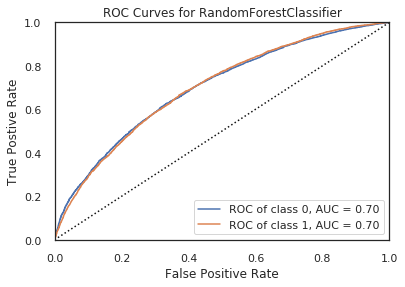

In [20]:
san.classification_sanity_check(loan_rf, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

### Explanation <a name=clfe>

In [21]:
loans_tree_explainer = shap.TreeExplainer(loan_rf)

In [22]:
sample_loans = ln_X_test.iloc[3]

## recovers the original format just for reading convenience
loans.data.iloc[[sample_loans.name], :]

loan_amnt  int_rate  installment  grade  emp_length home_ownership  \
41230     7000.0     15.61       244.76    4.0         1.0           RENT   

       annual_inc verification_status             purpose   dti  delinq_2yrs  \
41230     56550.0     Source Verified  debt_consolidation  23.6          1.0   

       inq_last_6mths  open_acc  revol_bal  revol_util  open_acc_6m  inq_fi  \
41230             1.0      10.0     2193.0        17.8          1.0     1.0   

       mths_since_crl_was_opened  bad_loan_status  
41230                  53.980575                1

In [23]:
sample_loans_shap_values = loans_tree_explainer.shap_values(sample_loans)

In [24]:
shap.force_plot(loans_tree_explainer.expected_value[1], sample_loans_shap_values[1], sample_loans, feature_names=ln_X_train.columns)

### We can see explanations for multiple data point and look for patterns

In [25]:
ln_X_test_samples = ln_X_test.sample(frac=0.05)

In [26]:
loans_samples_shap_values = loans_tree_explainer.shap_values(ln_X_test_samples)

In [27]:
# visualize 5% of loans test set 
shap.force_plot(loans_tree_explainer.expected_value[1], loans_samples_shap_values[1], ln_X_test_samples)

### We can understand how a single feature effects the output of the model 

We plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

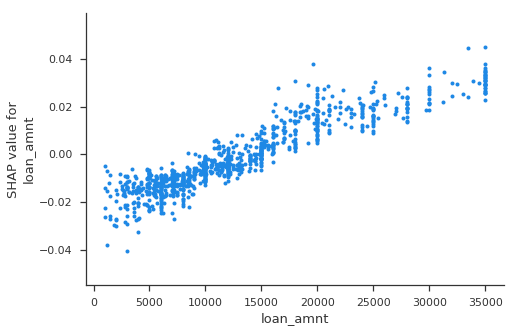

In [28]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("loan_amnt", loans_samples_shap_values[1], ln_X_test_samples, interaction_index=None)

In [29]:
#### Summarize the effects of all the features for Lending Club default prediction

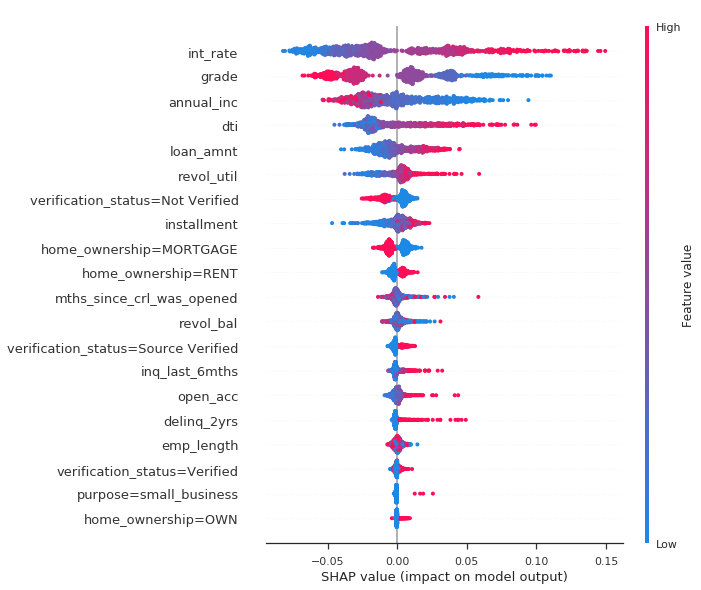

In [30]:
shap.summary_plot(loans_samples_shap_values[1], ln_X_test_samples)